## Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
import sys
sys.path.append('/mnt/4_TB_HD/ramona/utils')
from evaluation import evaluation_class
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import itertools

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from Read_data import read_data

/home/ramona/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load features that are ready for classification

In [2]:
path = '/mnt/4_TB_HD/ramona/utils/features/'
dt = '18-06-01-18-19'
X_train, Y_train, X_test, Y_test, Y_train_cateogorial, Y_test_cateogorial, stage2_transf, stage2_transf_filtered = read_data(dt)
stage2test_classes = pd.read_pickle('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2test_classes.sav')
stage2_y = stage2test_classes['Class'].values

In [3]:
# Use these for randomly chosen test set
#X_stack=np.vstack([X_train,X_test,stage2_transf_filtered])
#Y_stack=np.hstack([Y_train, Y_test,stage2_y])
#x1, test, y1, ytest = train_test_split(X_stack, Y_stack, test_size=125)
#print(x1.shape, y1.shape)

#Use these for testing on stage 2
X_stack = np.vstack([X_train,X_test])
Y_stack = np.hstack([Y_train, Y_test])
print(X_stack.shape, Y_stack.shape)

(3683, 400) (3683,)


### Oversampling

In [4]:
#X_resampled, Y_resampled = ADASYN(ratio='auto', random_state=None, k=None, n_neighbors=5, n_jobs=1).fit_sample(x1, y1)
X_resampled, Y_resampled = ADASYN(ratio='auto', random_state=None, k=None, n_neighbors=5, n_jobs=1).fit_sample(X_stack, Y_stack)
print(X_resampled.shape, Y_resampled.shape)

(9484, 400) (9484,)


## Grid-search for Classifier

In [5]:
clf = LogisticRegression()

In [6]:
parameters = {
    'tol':(1e-5,1e-4,1e-3),
    'class_weight':(None, 'balanced'), 
    #'penalty': ('l1', 'l2'),
    'solver': ('newton-cg', 'saga'), 
    'max_iter': (400, 1000),
    #'multi_class': ('multinomial')
}

In [7]:
grid_search = GridSearchCV(clf, param_grid = parameters, scoring = 'neg_log_loss', verbose = 1, n_jobs = 12)

print("Performing grid search...")
print("parameters:")
pprint(parameters)
t0 = time()

#grid_search.fit(x1,y1.astype(str)) #For randomly chosen test set
#grid_search.fit(X_stack,Y_stack.astype(str)) #For stage 2 test
grid_search.fit(X_resampled, Y_resampled.astype(str)) #If oversampling has been performed

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Done!")

Performing grid search...
parameters:
{'class_weight': (None, 'balanced'),
 'max_iter': (400, 1000),
 'solver': ('newton-cg', 'saga'),
 'tol': (1e-05, 0.0001, 0.001)}
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done  72 out of  72 | elapsed:  3.8min finished


done in 258.281s

Best score: -1.263
Best parameters set:
	class_weight: 'balanced'
	max_iter: 400
	solver: 'saga'
	tol: 0.001
Done!


## Prediction on test set

In [8]:
stage2test_classes = pd.read_pickle('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2test_classes.sav')
stage2test_classes.head()

,ID,Class
0,8,4
1,15,9
2,16,8
3,18,2
4,19,2


In [11]:
best_clf = grid_search.best_estimator_
Y_pred = best_clf.predict_proba(stage2_transf_filtered) #For stage2 test, predict on the private leaderboard
#Y_pred = best_clf.predict_proba(test) #For randomly chosen test

stage2_pred = best_clf.predict_proba(stage2_transf)

print(Y_pred[0])

[0.33265858 0.20839746 0.03541292 0.03305565 0.01303237 0.34337259
 0.02172793 0.00603768 0.00630483]


### Weighting the prediction

In [13]:
# Loading All fill 1/9 
submission_all_1_over_9 = pd.read_csv('submissions/submission_sample_fullwith01111.csv')
submission_all_1_over_9= submission_all_1_over_9.drop('ID', axis = 1).values[:125,:]

#weighted average
weighting = (10,1)
pred_weighted_average = (Y_pred*weighting[0] +submission_all_1_over_9*weighting[1])/10
pred_weighted_average[0]

array([0.34376969, 0.21950857, 0.04652403, 0.04416676, 0.02414348,
       0.3544837 , 0.03283904, 0.01714879, 0.01741595])

### Evaluation

/home/ramona/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.216 Log loss: 2.088450627113722 F1 micro: 0.216 F1 macro: 0.11880167011449833


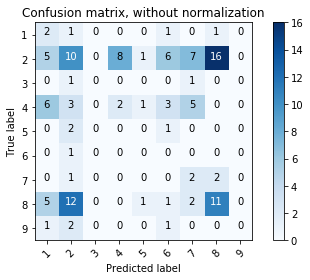

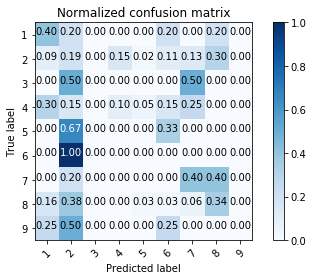

one row with the evaluation data is appended at /mnt/4_TB_HD/ramona/develop/results.csv


In [14]:
ev = evaluation_class('full', model = best_clf, y_pred = pred_weighted_average, Y_test=stage2test_classes['Class'])
#ev = evaluation_class('full', model = best_clf, y_pred = pred_weighted_average, Y_test=ytest)
ev.entire_evaluation()

## Save model

In [15]:
filename = 'log_full_oversampled' + dt 
pickle.dump(best_clf, open( filename, "wb" ) )

## Create kaggle submission

In [17]:
# Loading All fill 1/9 
submission_all_1_over_9 = pd.read_csv('submissions/submission_sample_fullwith01111.csv')
submission_all_1_over_9= submission_all_1_over_9.drop('ID', axis = 1).values
index = np.arange(1,987)

#weighted average
weighting = (10,1)
submission_weighted_average = (stage2_pred*weighting[0] +submission_all_1_over_9*weighting[1])/10

# transforming the weighted average into the right format and save it in submissions
submission_weighted_average = pd.DataFrame(submission_weighted_average, columns=['class'+str(c+1) for c in range(9)])
submission_weighted_average['ID'] = index
submission_weighted_average.to_csv('submissions/submission_logistic_regression_weighted_average'+str(weighting) + '.csv', index=False)
submission_weighted_average.shape

(986, 10)